# Finding true optical counterparts for X-ray AGNs in SDSS
Some galaxies have a very luminus central part, so luminus that can be brighter than remaining part of galaxy. The process of producing such an extraordeinary emissions are non-thermal (not from stars). An AGN emits strongly in X-ray or radio or ultraviolet wavelenghts or even in all of them. Mapping the sky using an X-ray telescope is a technique for finding AGNs. AGNs have a point-source shape in X-ray images. After detection of point sources in X-ray images and measuring their X-ray fluxes, astronomers try to find their fluxes in other bands spectialy in optical and near-infrared for further studies. X-ray satelite telescopes (usually) have very low spatial resolutions (~5 to 60 arcseconds) in comparison with the optical telescopes (~1 arcsecond). Thus assigning a detected point-source object in the X-ray to an optical counterpart is not so easy. An X-ray point source may cover several optical objects at the same place of the sky. So we need a method to find a true optical counterpart for an X-ray point sources among several optical sources close to be center of the X-ray emission.

AGNs have a very specific and distinct spectral shape. So one can find the true optical counterpart of an X-ray emission using spectroscopic data of optical counterpart canodidates. Getting spectral data is much more expensive in comparision with imaging. Taking into account that future X-ray satelite telescopes such as eROSITA will obseved millions of X-ray AGNs, collecting spectral data for few millions optical counterpart is not feasible. So a feasible approach would be classification of the counterpart candidates base on photometric data from optical or near-infrared imaging. For a small sample of X-ray AGNs and their true counterparts (known from spectroscopic follow-ups), one can train a machine learning classifier and apply it to predict true optical counterparts for other samples of X-ray AGNs. In following we use a sample of X-ray AGNs in SDSS (Sloan Digital Sky Survey) from Ananna et al 2017.

In [1]:
import photometryML as pML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Sample of X-ray AGNs in SDSS

Importing a data set consisting optical counterpart candidates for a sample of X-ray AGNs in Sloan Digital Sky Survey (SDSS). Each row of the data set belogs to an optical source. The columns are described as following:

REC_NO : ID for host X-ray source

XRAY_RA : Right acsension of the X-ray point source

XRAY_DEC : Declination of the X-ray point source

LABEL : 1 if the object is the true counterpart of the X-ray source and 0 if not.

*_mag_auto : magnitude of the object in u, g, r, i and z. The missing values is 99.0.

err_*_mag_auto : error in magnitude of the object in u, g, r, i and z. The missing values is 99.0.

Let's import the dataset 'SDSS_AGNs.csv' into a pandas DataFrame:

In [2]:
data_init = pd.read_csv('SDSS_AGNs.csv')
data_init.head(6)

,REC_NO,XRAY_RA,XRAY_DEC,LABEL,u_mag_auto,err_u_mag_auto,g_mag_auto,err_g_mag_auto,r_mag_auto,err_r_mag_auto,i_mag_auto,err_i_mag_auto,z_mag_auto,err_z_mag_auto,Separation
0,1393,333.483124,-0.415928,1,21.6121,0.0688,20.9310,0.0183,20.2042,0.0139,19.8759,0.0128,19.5285,0.0297,1.942150
1,1393,333.483124,-0.415928,0,24.8784,1.3421,22.9278,0.0899,22.5800,0.0994,21.4011,0.0542,21.4606,0.1978,9.689301
2,1396,333.530365,0.123070,1,20.7762,0.0457,20.5685,0.0153,20.3769,0.0165,20.3655,0.0211,20.2366,0.0650,4.378376
3,1400,333.551422,-0.169640,1,21.1818,0.0646,20.4733,0.0149,19.5872,0.0107,19.1251,0.0101,18.6559,0.0218,1.982205
4,1400,333.551422,-0.169640,0,28.5398,33.9942,23.8509,0.1559,23.5943,0.1926,23.2036,0.2127,22.3337,0.3745,8.254678
5,1406,333.597626,0.291508,0,21.0686,0.0550,19.9107,0.0109,19.4274,0.0093,19.1972,0.0102,19.1168,0.0271,8.961749


The first to rows have the same 'REC_NO' (1393). As mentiond before, it means that they are close to the same X-ray source.

# Data Partitioning

The data set need to be devided to train, validation and test samples. The function 'data_partition_cc' devides a data sets into train, validation and test samples randomly. The advantage of this function in comparison to the 'train_test_split' in 'sklearn' package is that it can devide the sample base on common column value. For example, in SDSS AGN sample, we prefer to keep objects with the same host X-ray source (common REC_NO) in the sample of trian or test. The fraction of train, validation and test samples set to 0.7, 0 and 0.3.

In [3]:
train_init, valid_init, test_init = pML.photometry.data_partition_cc(data = data_init,
                                                                     train_frac = 0.7, 
                                                                     valid_frac = 0.0, 
                                                                     test_frac = 0.3,
                                                                     grouping_column = 'REC_NO', 
                                                                     random_seed = 0, 
                                                                     return_boolean = False)

Now we check the size of train and test sample and whether their ratio is ~7/3 or not:

In [4]:
print('size of train sample:', len(train_init))
print('size of train sample:', len(test_init))
print('ratio of size of train and test samples:', len(train_init) / len(test_init))

size of train sample: 3355
size of train sample: 1549
ratio of size of train and test samples: 2.1659134925758554


## working with photometric data

A photometric data consists of information of astronoical objects such as position in the sky, magnitudes, redshift, etc. Usually the not all the mentioned measurables are available for all the objects. For example one galaxy may have measured magnitudes in g and r band but its magnitude is not measured because it is too faint to be detected by limited time of observation. For such cases in photometric data sets, the missing value replace by a specific value out of normal range of parameter. For example, magnitude of the galaxies varies between 10 to 30 magnitude and missing value for missing magnitude value can be -99 or 9999.

Astronomers use the color parameters as an important parameter for evolution history and physical prperties of the stars and galaxies. Color parameter computed by subtracting two magnitude of single object. Thus for computing color parameter, one should consider the missing values for magnitudes.

'PhotomCleanData' is a class in 'photometryML.photometry' module which stores a photometric data set and for a given set of columns returns rows with no missing value in any of requested column. It also automitically compute color parameters.

We store train and test samples into two 'PhotomCleanData' objects:

In [5]:
train_data_obj = pML.photometry.PhotomCleanData(input_data = train_init, missing_value = 99.000 )
test_data_obj  = pML.photometry.PhotomCleanData(input_data = test_init, missing_value = 99.000 )

'PhotomCleanData' has 'return_data' method that return a set of requested columns with clean rows (without missing value). 'return_data' has following parameters and returns a pandas.DataFrame object:

        init_x_columns : list
            List of columns name for features excluding colors that are expected
            to be created by this class
            
        init_x_columns_err : list, optional
            List of columns name representing the errors for 'init_x_columns'. 
            The order and size of 'init_x_columns' and 'init_x_columns_err' must
            be similar.
            
        mag_columns_4color1 : list, optional 
            List of magnitudes names (columns name) that are used as the first 
            magnitude in the color computation (m1 in c = m1 - m2).
        
        mag_columns_4color2 : list, optional
            List of magnitudes names (columns name) that are used as the second 
            magnitude in the color computation (m2 in c = m1 - m2).
        
        mag_columns_4color1_err : list, optional
            List of columns name representing the errors for 'mag_columns_4color1'. 
            The order and size of 'mag_columns_4color1' and 'mag_columns_4color1_err' must
            be similar.
        
        mag_columns_4color2_err : list, optional
            List of columns name representing the errors for 'mag_columns_4color2'. 
            The order and size of 'mag_columns_4color2' and 'mag_columns_4color2_err' must
            be similar.        
            
        y_column: string, optional
            Y column name 
            
For example:


In [6]:
init_x_columns = ['g_mag_auto','r_mag_auto','Separation']

init_x_columns_err = []

mag_columns_4color1 = ['u_mag_auto', 'g_mag_auto',]

mag_columns_4color2 = ['g_mag_auto', 'r_mag_auto']             

mag_columns_4color1_err = ['err_u_mag_auto', 'err_g_mag_auto']
mag_columns_4color2_err = ['err_g_mag_auto', 'err_r_mag_auto']   

y_column = 'LABEL'

train_sample = train_data_obj.return_data(init_x_columns = init_x_columns, 
                                          init_x_columns_err = init_x_columns_err,
                                 mag_columns_4color1 = mag_columns_4color1,
                                 mag_columns_4color2 = mag_columns_4color2,
                                 mag_columns_4color1_err = mag_columns_4color1_err, 
                                 mag_columns_4color2_err = mag_columns_4color2_err,
                                 y_column = y_column,
                                 valid_values_only = True)

test_sample = test_data_obj.return_data(init_x_columns = init_x_columns, 
                                 init_x_columns_err = init_x_columns_err,
                                 mag_columns_4color1 = mag_columns_4color1,
                                 mag_columns_4color2 = mag_columns_4color2,
                                 mag_columns_4color1_err = mag_columns_4color1_err, 
                                 mag_columns_4color2_err = mag_columns_4color2_err,
                                 y_column = y_column,
                                 valid_values_only = True)

And the columns in the returned data frame:

In [7]:
train_sample.head()

,LABEL,g_mag_auto,r_mag_auto,Separation,u_mag_auto-g_mag_auto,u_mag_auto-g_mag_auto_err,g_mag_auto-r_mag_auto,g_mag_auto-r_mag_auto_err
2831,1,19.9608,19.6457,1.364414,0.2576,0.035070,0.3151,0.015346
2833,1,19.2239,18.9901,0.154053,0.1298,0.022239,0.2338,0.010608
4659,1,11.9935,11.6774,1.037514,0.0025,0.000762,0.3161,0.000361
2838,0,23.5515,22.8572,4.860970,0.5935,0.632400,0.6943,0.167467
2837,0,23.4784,22.7292,4.625156,1.7106,1.475602,0.7492,0.145659


The color parameters and their errors are automitically calculated and only requested columns are returned. The rows with missing values in requested columns are also excluded.

To simplify working with X columns (called features in machine learning) and Y column (labels), a PhotomCleanData has some attributes to "rememebr" which columns belong to features and labels. 

In [8]:
print('features:', train_data_obj.x_columns)
print('features:', train_data_obj.y_column)

features: ['g_mag_auto', 'r_mag_auto', 'Separation', 'u_mag_auto-g_mag_auto', 'g_mag_auto-r_mag_auto']
features: LABEL


## Machine Learning Pipeline

The 'sklearn.pipeline' module provides 'Pipeline' class that sequentially applies a list of transforms and a final estimator. After each training using 'Pipeline' the accuracy (performance) of the estimator should be separately evaluated. In addition to the functionality of 'Pipeline', the 'MLPipeline' class in 'photometryML.machinelearning' module automatically computed the accuracy, confusion matrix and completeness/purity for each class of labels.

A MLPipeline is created by follwoing arguments:

    'classifier': an object from classifier classes in 'sklearn' package. 
    For example: sklearn.neural_network.MLPClassifier or sklearn.svm.SVC objects.
    
    'std_scale': If True, sklearn.preprocessing.StandardScaler is included in the
    pipeline. Default: True
    
    'pca': If True, 'principal component analysis' (PCA) is applied by 
    including a sklearn.decomposition.PCA object in the pipeline to extract 
    'n_components' number of features. The goal is to reduce the dimensionality.
    Default: False
    
    'n_components': number of extracted features in PCA method. The same argument
    as in 'sklearn.decomposition.PCA'.

For instance, we create a random forest classifier and add it to a MLPipeline object and apply it on the train sample. We also apply PCA (principal component analysis) with 5 degree (number of features).

In [9]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=300, 
                                    min_samples_leaf = 30,
                                    random_state=0, n_jobs=-1, 
                                    class_weight = 'balanced')

forest = pML.machinelearning.MLPipeline(classifier = classifier,
                                        classifier_name = "Forest", 
                                        std_scale = False, 
                                        if_pca = True, 
                                        pca_number = 5)
forest.fit(train_sample[train_data_obj.x_columns], train_sample[train_data_obj.y_column])

The 'fit' method of MLPipeline works extacly like 'fit' of 'sklearn.pipeline'. Now we show the difference. By calling the 'fi' method the MLPipeline automatically evaluates the quality of the classification on train sample in three different attributes:

In [10]:
print("accuracy of classification on train sample:")
print(forest.fit_accuracy)
print("")
print("confusion matrix of classification on train sample:")
print(forest.fit_confusion_matrix)
print("")
print("performance of classification on train sample:")
print(forest.fit_performance)

accuracy of classification on train sample:
0.9338306843983133

confusion matrix of classification on train sample:
[[1564  128]
 [  76 1315]]

performance of classification on train sample:
   class  true_number  predicted_number  completeness    purity
0      0         1692              1640      0.924350  0.953659
1      1         1391              1443      0.945363  0.911296


The 'predict' method of 'MLPipeline' works extacly like 'predict' of 'sklearn.pipeline' too and have similar attributes:

In [11]:
test_sample['predicted_label'] = forest.predict(test_sample[test_data_obj.x_columns], test_sample[test_data_obj.y_column])

print("accuracy of classification on test sample:")
print(forest.predict_accuracy)
print("")
print("confusion matrix of classification on test sample:")
print(forest.predict_confusion_matrix)
print("")
print("performance of classification on test sample:")
print(forest.predict_performance)

accuracy of classification on test sample:
0.9267782426778243

confusion matrix of classification on test sample:
[[747  68]
 [ 37 582]]

performance of classification on test sample:
   class  true_number  predicted_number  completeness    purity
0      0          815               784      0.916564  0.952806
1      1          619               650      0.940226  0.895385


## Fine Tuning

There are some free parameters in each machine learning model that can change the accuracy of the model in predicton.
The 'Tuner' class in 'phoometryML.photometry' module tunes a 'MLPipeline'. For given ranges of free parameters, 
it uses k-fold validation method and computes the accuracy and list them. A Tuner object is build by following argument and has follwoing methods and attribues:

    parameters:
    -----------
    clf : a sklearn classifier object or a 'MLPipeline' object
    
    fixed_args: A dictionary of the parameters (arguments) of 'clf' which 
    have to be fixed
        
    variable_arg : A parameter name of 'clf' that is supposed to varie for 
    tuning
        
    variable_arg_values: Given values for chaning 'variable_param'
    
    n_splits : number of random validation and training sampling 
    std_scale : If True standardization scaling is applied.
    
    
    Methods
    -------
    tune : gets data and run tuning. The results are saved in 
    'predict_performance_mean' and 'predict_performance_std' attributes.
    
    Attributes:
    -----------
    classes : list of labels in 'y_data'
        
    accuracy : A dataframe including the means and standard deviations of
    classification accuracy for given range of 'variable_arg_values', for both
    train and validation samples.
    
    training_performance_list : list of performance dataframes for training 
    subsamples


In [12]:
fixed_args = {'class_weight' : 'balanced_subsample', 
              'random_state' : 0, 
              'n_jobs' : -1}

tuner = pML.tuning.Tuner(clf = RandomForestClassifier, 
                         fixed_args = fixed_args,
                         variable_args = ['n_estimators','min_samples_leaf'], 
                         variable_args_values = [ np.array([10,30,100,300]),
                                                   np.array([1,3,10,30]) ],
                         std_scale = False, 
                         if_pca = True, 
                         pca_number = 5,
                         clf_type = 'clf',
                         n_splits = 4)

tuner.tune(train_sample[train_data_obj.x_columns], train_sample[train_data_obj.y_column])
print(tuner.accuracy)

    n_estimators  min_samples_leaf  train_accuracy_mean  train_accuracy_STD  \
0             10                 1             0.928646            0.008815   
1             10                 3             0.930915            0.007445   
2             10                10             0.930914            0.008505   
3             10                30             0.925077            0.011985   
4             30                 1             0.931240            0.006770   
5             30                 3             0.931565            0.009653   
6             30                10             0.929942            0.011474   
7             30                30             0.924752            0.012184   
8            100                 1             0.932860            0.006419   
9            100                 3             0.932537            0.008128   
10           100                10             0.929617            0.011232   
11           100                30             0.924

## Plotting decision regions
Visualizing the classification of the data point is helpful and crucial to improving the performance of machine learning method, although using more than two features in visualization is too complicated.
At this part of this instruction, we introduce 'plot_decision_regions' function in 'photometryML.plot' module for visualizing the decision regions for a given and trained classifier. 


    Parameters:
    -----------
    X : pandas.DataFrame
        A dataframe consists of features and label
        
    x_columns : list
        A list with length of 2. It includes column names of two features.
    
    y_column : string
        Name of column for labels.
        
    plot_title : string, optional
        Title of plot.
        
    xlabel : string
        Label for the X-axis of the plot.
        
    ylabel : string
        Label for the Y-axis of the plot.
        
    resolution : double
        The size of regions for sampling the prediction. default value set to 0.05
        
    plotFile : string, optional
        File name for saving the plot. The plot will save only if a name is
        given.

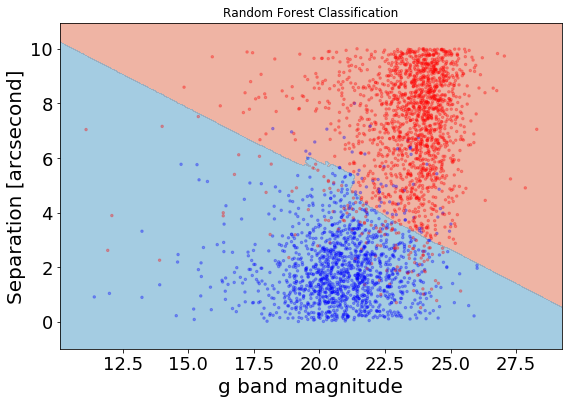

In [13]:
forest = pML.machinelearning.MLPipeline(classifier = classifier,
                                        classifier_name = "Forest", 
                                        std_scale = False, 
                                        if_pca = True, 
                                        pca_number = 2)

forest.fit(train_sample[['g_mag_auto','Separation']], train_sample['LABEL'])

pML.plot.plot_decision_regions(X = train_sample, 
                      x_columns = ['g_mag_auto','Separation'], 
                      y_column = 'LABEL', 
                      classifier = forest, 
                      plot_title = 'Random Forest Classification', 
                      xlabel = 'g band magnitude', 
                      ylabel = 'Separation [arcsecond]',
                      resolution=0.05, 
                      plotFile = None)
